# Homework 4

In [1]:
import pandas as pd
import numpy as np
import wget
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
#data = wget.download('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

We'll work with the MSRP variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:
* Make,
* Model,
* Year,
* Engine HP,
* Engine Cylinders,
* Transmission Type,
* Vehicle Style,
* highway MPG,
* city mpg
* MSRP

## Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average  
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [6]:
# Keeping only the neccessary columns
df = df[['Make',
'Model',
'Year',
'Engine HP',
'Engine Cylinders',
'Transmission Type',
'Vehicle Style',
'highway MPG',
'city mpg',
'MSRP']]

df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [7]:
# Lowercasing the column names and replacing spaces with underscores
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [8]:
# Checking missing values
df.isna().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [9]:
# Filling the missing values with 0
df = df.fillna(0)
df.isna().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [10]:
# Making the price binary (1 if above the average, 0 otherwise)
dfp = df.copy()
df['above_average'] = (df['msrp'] > df['msrp'].mean()).astype(int)

In [11]:
# Deleting the 'msrp' (price) column
del df['msrp']

In [12]:
# Splitting the data into 3 parts: train/validation/test with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [13]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_val['above_average']
del df_test['above_average']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that  
* For each numerical variable, use it as score and compute AUC with the above_average variable
* Use the training dataset for that  
If your AUC is < 0.5, invert this variable by putting "-" in front
(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.  

Which numerical variable (among the following 4) has the highest AUC?
* engine_hp
* engine_cylinders
* highway_mpg
* city_mpg

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7148 entries, 0 to 7147
Data columns (total 9 columns):
make                 7148 non-null object
model                7148 non-null object
year                 7148 non-null int64
engine_hp            7148 non-null float64
engine_cylinders     7148 non-null float64
transmission_type    7148 non-null object
vehicle_style        7148 non-null object
highway_mpg          7148 non-null int64
city_mpg             7148 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 502.7+ KB


In [16]:
numerical = list(df_train.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
feature_importance = {}  # Creating a dictionary to store feature importance scores

for feature in df_train[numerical]:
    # Calculating ROC AUC for each feature
    auc_score = roc_auc_score(y_train, df_train[feature])
        
    if auc_score < 0.5:
        # If AUC is less than 0.5, inverting the variable
        inverted_feature = -df_train[feature]
        auc_score = roc_auc_score(y_train, inverted_feature)
        feature_importance[feature] = auc_score
    else:
        feature_importance[feature] = auc_score

# Sorting features by ROC AUC score in descending order to get the most important features
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Printing the sorted feature importance
for feature, auc_score in sorted_feature_importance:
    print(f"Feature: {feature}, ROC AUC: {auc_score}")

Feature: engine_hp, ROC AUC: 0.9171031265539011
Feature: engine_cylinders, ROC AUC: 0.766116490165669
Feature: year, ROC AUC: 0.687551492804683
Feature: city_mpg, ROC AUC: 0.6734244643245233
Feature: highway_mpg, ROC AUC: 0.6330587871772013


Answer: engine_hp

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)
* 0.678
* 0.779
* 0.878
* 0.979

In [19]:
dv = DictVectorizer(sparse=False)

# Applying one-hot encoding to the training data
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Training the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
# Applying one-hot encoding to the validation data
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Making predictions on the validation data
y_pred = model.predict_proba(X_val)[:, 1]

# Calculating the AUC score
auc = roc_auc_score(y_val, y_pred)

# Printing the AUC rounded to 3 digits
print(f"AUC on the validation dataset: {auc:.3f}")

AUC on the validation dataset: 0.980


Answer: 0.979

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.
* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?
* 0.28
* 0.48
* 0.68
* 0.88

### Variant 1

In [21]:
scores = []

thresholds = np.arange(0, 1.01, 0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [22]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

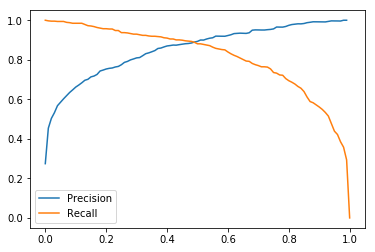

In [23]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()

### Variant 2

C:\Users\valkm\AppData\Local\Continuum\anaconda3\envs\retinanet\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


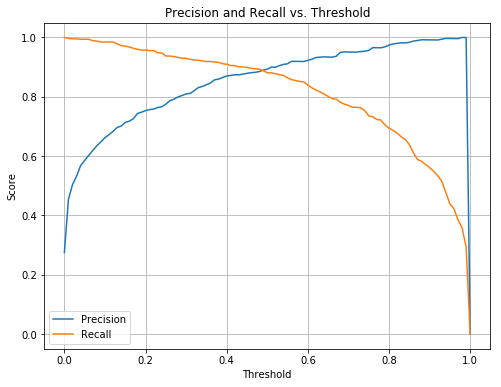

In [24]:
from sklearn.metrics import precision_score, recall_score

# Creating an array of thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Initializing lists to store precision and recall values
precision_values = []
recall_values = []

# Calculating precision and recall for each threshold
for threshold in thresholds:
    # Applying the threshold to the predicted probabilities to make binary predictions
    binary_predictions = (y_pred >= threshold).astype(int)

    # Calculating precision and recall
    precision = precision_score(y_val, binary_predictions)
    recall = recall_score(y_val, binary_predictions)

    precision_values.append(precision)
    recall_values.append(recall)

# Creating a plot showing precision and recall across thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_values, label='Precision')
plt.plot(thresholds, recall_values, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid()
plt.show()

Answer: 0.48

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?
* 0.12
* 0.32
* 0.52
* 0.72

### Variant 1

In [25]:
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr,p,r
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000
1,0.01,652,784,2,945,0.996942,0.453441,0.454039,0.996942
2,0.02,651,642,3,1087,0.995413,0.371313,0.503480,0.995413
3,0.03,651,572,3,1157,0.995413,0.330827,0.532298,0.995413
4,0.04,650,495,4,1234,0.993884,0.286293,0.567686,0.993884


In [26]:
# Calculating F1-score for each threshold
f1_scores = 2 * (df_scores['p'].to_numpy() * df_scores['r'].to_numpy()) / (df_scores['p'].to_numpy() + df_scores['r'].to_numpy())

In [27]:
df_scores['f1'] = f1_scores

In [28]:
df_scores.head()

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,f1
0,0.00,654,1729,0,0,1.000000,1.000000,0.274444,1.000000,0.430688
1,0.01,652,784,2,945,0.996942,0.453441,0.454039,0.996942,0.623923
2,0.02,651,642,3,1087,0.995413,0.371313,0.503480,0.995413,0.668721
3,0.03,651,572,3,1157,0.995413,0.330827,0.532298,0.995413,0.693660
4,0.04,650,495,4,1234,0.993884,0.286293,0.567686,0.993884,0.722624


In [29]:
# Finding the threshold with the maximum F1-score
df_scores[df_scores.f1 == df_scores.f1.max()]

,threshold,tp,fp,fn,tn,tpr,fpr,p,r,f1
51,0.51,576,64,78,1665,0.880734,0.037016,0.9,0.880734,0.890263


### Variant 2

In [30]:
from sklearn.metrics import f1_score

# Calculating F1-score for each threshold
f1_scores = [2 * (precision * recall) / (precision + recall) for precision, recall in zip(precision_values, recall_values)]

# Finding the threshold with the maximum F1-score
max_f1_score = max(f1_scores)
optimal_threshold = thresholds[f1_scores.index(max_f1_score)]

print(f"Precision and Recall curves intersect at threshold: {optimal_threshold:.2f}")

Precision and Recall curves intersect at threshold: 0.51


C:\Users\valkm\AppData\Local\Continuum\anaconda3\envs\retinanet\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


### Variant 3

In [31]:
# Creating an array of thresholds from 0.0 to 1.0 with an increment of 0.01
thresholds = np.arange(0, 1.01, 0.01)

# Initializing a list to store F1 scores
f1_scores = []

# Calculating F1-score for each threshold
for threshold in thresholds:
    # Applying the threshold to the predicted probabilities to make binary predictions
    binary_predictions = (y_pred >= threshold).astype(int)

    # Calculating the F1-score
    f1 = f1_score(y_val, binary_predictions)
    f1_scores.append(f1)

# Finding the threshold at which F1 is maximal
max_f1 = max(f1_scores)
optimal_threshold = thresholds[f1_scores.index(max_f1)]

print(f"Threshold at which F1 is maximal: {optimal_threshold:.2f}")

Threshold at which F1 is maximal: 0.51


C:\Users\valkm\AppData\Local\Continuum\anaconda3\envs\retinanet\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Answer: 0.52

## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)
* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?
* 0.003
* 0.030
* 0.090
* 0.140

In [32]:
from sklearn.model_selection import KFold

In [33]:
# Define the KFold cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a list to store AUC scores
auc_scores = []

# Initialize the one-hot encoding transformation
dv = DictVectorizer(sparse=False)

# Iterate over different folds
for train_index, val_index in kf.split(df_train_full):
    # Split the data into train and validation sets
    train_data, val_data = df_train_full.iloc[train_index], df_train_full.iloc[val_index]
    
    # Extract features and target variables
    X_train = train_data.drop(columns=['above_average'])
    y_train = train_data['above_average']
    X_val = val_data.drop(columns=['above_average'])
    y_val = val_data['above_average']
    
    # Apply the one-hot encoding transformation to both training and validation data
    X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
    
    # Create and train the logistic regression model with the specified parameters
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)
    
    # Make predictions on the validation set
    y_pred = model.predict_proba(X_val_encoded)[:, 1]
    
    # Calculate the AUC score for this fold and store it
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

# Calculate the standard deviation of the AUC scores across the different folds
std_dev = np.std(auc_scores)

In [34]:
std_dev.round(3)

0.002

Answer: 0.003

## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 0.5, 10]
* Initialize KFold with the same parameters as previously
* Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?
* 0.01
* 0.1
* 0.5
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [35]:
# Specify the values of C to be tested
C_values = [0.01, 0.1, 0.5, 10]

# Initialize a dictionary to store the results for each C value
results = {}

# Initialize StratifiedKFold with the same parameters as previously
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Iterate over different C values
for C in C_values:
    # Initialize a list to store AUC scores for each fold
    auc_scores = []

    # Create and train the logistic regression model with the specified C value
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    # Iterate over different folds
    for train_index, val_index in kf.split(df_train_full, df_train_full['above_average']):
        # Split the data into train and validation sets
        train_data, val_data = df_train_full.iloc[train_index], df_train_full.iloc[val_index]
    
        # Extract features and target variables
        X_train = train_data.drop(columns=['above_average'])
        y_train = train_data['above_average']
        X_val = val_data.drop(columns=['above_average'])
        y_val = val_data['above_average']
    
        # Apply one-hot encoding as needed
        X_train_encoded = dv.fit_transform(X_train.to_dict(orient='records'))
        X_val_encoded = dv.transform(X_val.to_dict(orient='records'))
    
        # Train the logistic regression model on the training set
        model.fit(X_train_encoded, y_train)
    
        # Make predictions on the validation set
        y_pred = model.predict_proba(X_val_encoded)[:, 1]
    
        # Calculate the AUC score for this fold and store it
        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    # Calculate the mean and standard deviation of AUC scores for this C value
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    # Store the results in the dictionary
    results[C] = (round(mean_auc, 3), round(std_auc, 3))

# Print the results
best_c = None
best_mean_auc = 0

for C, (mean_auc, std_auc) in results.items():
    print(f"C = {C}: Mean AUC = {mean_auc}, Std = {std_auc}")
    
    if mean_auc > best_mean_auc:
        best_mean_auc = mean_auc
        best_c = C

print(f"The best C is {best_c} with a mean AUC of {best_mean_auc}")

C = 0.01: Mean AUC = 0.952, Std = 0.002
C = 0.1: Mean AUC = 0.972, Std = 0.002
C = 0.5: Mean AUC = 0.978, Std = 0.003
C = 10: Mean AUC = 0.984, Std = 0.003
The best C is 10 with a mean AUC of 0.984


Answer: 10